### Model Optimizing

This notebook is about techniques how to find a good model architecture. 

If using Multilayer Neural Networks it is always a challenge to find the right size of the hidden layers to get good result. There is no formula you can use, because the solution depends on many properties of the used data. First we have the size of the inputs and outputs, then we have the size of the observations, and we also have the complexity of the data (how many degrees of freedon are inside the data, which have to be learned)

For starting to solve this problem a group models with a wide range of different layer sizes can be used. Comparing the KPIs in most cases gives you an overview, which model configurations can be used for further optimizations. 

#### Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from IPython.display import display

seed=8172
np.random.seed(seed)
tf.random.set_seed(seed)
ts_input_size=12
ts_target_size=12

# Read the data
df=pd.read_csv("../data/AirPassengers.csv")
df.columns=["Period","Passengers"]
dfTraining=df.iloc[:-ts_target_size].copy()

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0.1, 0.9))
series_scaled = scaler.fit_transform(dfTraining["Passengers"].values.reshape(-1,1))
dfTraining["PassengersScaled"]=series_scaled

training_flat=dfTraining["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX=[]
trainY=[]
for i in range(len(training_flat)-ts_target_size-ts_input_size+1):
    x=training_flat[i:(i+ts_input_size),0]
    y=training_flat[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX.append(x)
    trainY.append(y)

# Training data
trainX=np.array(trainX)
trainY=np.array(trainY)
from sklearn.model_selection import train_test_split
x_trainbatches, x_testbatches, y_trainbatches, y_testbatches = train_test_split(
            trainX, trainY, test_size=0.1, random_state=42)
x_testbatches

# Forecast input
predictX=[training_flat[-ts_input_size:,0]]
predictX=np.array(predictX)

#### Train a wide range of models

In [2]:
def show_loss(history,skipFirst=True):
    print("Last Results loss:{}, cross validation loss:{}".format(history.history['loss'][-1],history.history['val_loss'][-1]))
    plt.figure(figsize=(20,10))
    start=100 if skipFirst else 0
    plt.plot(history.history["val_loss"][start:], label="Cross Validation Loss")
    plt.plot(history.history["loss"][start:], label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Results - Training vs. Cross Validation (Mean Squared Error)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()  

def show_results(df,predictX,predictY):
    outputsize=len(predictY[0])
    inputsize=len(predictX[0])
    absDeviation=np.sum(np.abs(df["Passengers"].values[-outputsize:]-predictY[0]))
    absError=absDeviation/np.sum(predictY[0])*100
    print("          Forecast : {}\r\n            Actual : {}\r\nAbsolute Deviation : {} Passengers\r\n    Absolute Error : {:3.2f}%".format(
        predictY.astype(int)[0],df["Passengers"].values[-outputsize:],absDeviation,absError))    
    y0=df["Passengers"].values
    y1=[None for x in range(df.shape[0]-outputsize-inputsize)]
    y1.extend(predictX[0])
    y1=np.array(y1)
    y2=[None for x in range(df.shape[0]-outputsize)]
    y2.extend(predictY[0])
    y2=np.array(y2)
    plt.figure(figsize=(20,10))
    plt.plot(y0,label='Actual')
    plt.plot(y1,label='Input for Forecast')
    plt.plot(y2, label= 'Forecast')
    plt.xlabel("Period")
    labels=[df["Period"].iloc[x] for x in range(0,df.shape[0],12)]
    plt.xticks(range(0,df.shape[0],12),labels=labels, rotation=45)
    plt.ylabel("Number of Passenger")
    plt.title("Forecast Airline Passenger")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()    


def buildAndTrainModel(layerSize1,layerSize2, usebias=True):
    model=keras.Sequential()
    model.add(keras.layers.Dense(layerSize1,activation=keras.layers.LeakyReLU(), input_dim=ts_input_size, use_bias=usebias))
    if layerSize2 is not None:
        model.add(keras.layers.Dense(layerSize2,activation=keras.layers.LeakyReLU(), use_bias=usebias))
    model.add(keras.layers.Dense(ts_target_size, activation=keras.layers.LeakyReLU(), use_bias=usebias))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )
    earlyStopCB= keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=100,verbose=0,mode='auto')
    history=model.fit(x_trainbatches, y_trainbatches, epochs=10000,verbose=0,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               use_multiprocessing=True, callbacks=[earlyStopCB])
    predictY=scaler.inverse_transform(model.predict(predictX))
    return model,history,predictY



Next, I will build a range of models with tiny, small, midsize and large models.

In [3]:
layer1=[]
layer2=[]
models=[]
histories=[]
pYCol=[]
deviations=[]
absErrors=[]
lossCol=[]
lossValCol=[]
epochsCol=[]


baseModels=[
    [12,None], # tiny
    [40,None], #small
    [24,12],
    [40,20],
    [100,None], # midsize
    [150,20],
    [200,30],
    [1000,None], # large
    [400,200],
    [1000,500]
]
for s1 in baseModels:
    layer1.append(s1[0])
    layer2.append(s1[1])
print(layer1)
print(layer2)

[12, 40, 24, 40, 100, 150, 200, 1000, 400, 1000]
[None, None, 12, 20, None, 20, 30, None, 200, 500]


In [4]:
for i in range(len(layer1)):
    m,h,pY=buildAndTrainModel(layer1[i],layer2[i])
    models.append(m)
    histories.append(h)
    pYCol.append(pY)
    outputsize=len(pY[0])
    inputsize=len(predictX[0])
    lossCol.append(h.history["loss"][-1])
    lossValCol.append(h.history["val_loss"][-1])
    epochsCol.append(len(h.history["loss"]))

    deviations.append(np.sum(np.abs(df["Passengers"].values[-outputsize:]-pY[0])))
    absErrors.append(deviations[i]/np.sum(pY[0])*100)


In [5]:
for i in range(len(layer1)):
    print("Model {}: L1:{} L2:{} mse_train:{:.5f} mse_val:{:.5f} Dev:{} Error:{}".format(
        i,layer1[i],layer2[i],lossCol[i],lossValCol[i], deviations[i],absErrors[i]))


Model 0: L1:12 L2:None mse_train:0.00065 mse_val:0.00078 Dev:161.53643798828125 Error:2.8350304869792766
Model 1: L1:40 L2:None mse_train:0.00061 mse_val:0.00080 Dev:145.58499145507812 Error:2.550618877268719
Model 2: L1:24 L2:12 mse_train:0.00072 mse_val:0.00096 Dev:130.49017333984375 Error:2.2937539626634385
Model 3: L1:40 L2:20 mse_train:0.00076 mse_val:0.00087 Dev:216.54019165039062 Error:3.8461852435309662
Model 4: L1:100 L2:None mse_train:0.00062 mse_val:0.00077 Dev:149.17984008789062 Error:2.620448003347089
Model 5: L1:150 L2:20 mse_train:0.00054 mse_val:0.00079 Dev:147.389404296875 Error:2.5673254910819536
Model 6: L1:200 L2:30 mse_train:0.00057 mse_val:0.00079 Dev:141.93466186523438 Error:2.486897750156435
Model 7: L1:1000 L2:None mse_train:0.00059 mse_val:0.00076 Dev:145.73495483398438 Error:2.558741212249236
Model 8: L1:400 L2:200 mse_train:0.00055 mse_val:0.00076 Dev:146.09988403320312 Error:2.5608024911659446
Model 9: L1:1000 L2:500 mse_train:0.00055 mse_val:0.00077 Dev:14

In [6]:
dfResult=pd.DataFrame()
dfResult["Layer1"]=layer1
dfResult["Layer2"]=layer2
dfResult["Loss"]=lossCol
dfResult["ValLoss"]=lossValCol
dfResult["DiffLoss"]=dfResult["ValLoss"]-dfResult["Loss"]
dfResult["Epochs"]=epochsCol
dfResult["FC-Deviation"]=deviations
dfResult["FC-AbsError"]=absErrors
dfResult.sort_values(by=["ValLoss"])

,Layer1,Layer2,Loss,ValLoss,DiffLoss,Epochs,FC-Deviation,FC-AbsError
8,400,200.0,0.000547,0.000758,0.000211,665,146.099884,2.560802
7,1000,NaN,0.000590,0.000761,0.000170,1015,145.734955,2.558741
4,100,NaN,0.000623,0.000773,0.000149,2046,149.179840,2.620448
9,1000,500.0,0.000553,0.000773,0.000221,393,140.513153,2.464879
0,12,NaN,0.000645,0.000777,0.000132,9047,161.536438,2.835030
5,150,20.0,0.000543,0.000785,0.000243,2631,147.389404,2.567325
6,200,30.0,0.000573,0.000786,0.000212,1922,141.934662,2.486898
1,40,NaN,0.000614,0.000802,0.000188,4077,145.584991,2.550619
3,40,20.0,0.000764,0.000872,0.000109,1846,216.540192,3.846185
2,24,12.0,0.000725,0.000958,0.000234,2861,130.490173,2.293754


It seems that this data works with a large range of models very good. The Errors are small and the report does not show a trend were to go, but with a deeper look there are some indicators you could be aware of.

A large model tends to build a exact representation of the training data and it does not generalize much. This results in low training losses and on the validations side after a few epochs it tends to reach a minimum and rises afterworth again. The model 8 and model 7 shows exactly this behavior as the early break is activated at around 1000 epochs.

Model 2 which is in comaparison a midsize model does much more generalize the data. It needs about 2600 epochs until it tends to overfit. 

Small and tiny models in our case results in lower quality.

#### Conclusio

Without knowing the real data and situation we have there with validation losses near together, I always prefer the models with the lower sizes. They are more robust in comparison to unknown data. So I would prefer midsize models and make another test using a smaller range around the midsize models.

Then I would choose one or two models out of the range with good results and make another run where I use K-Fold Cross Validation. This method iterates over the whole training data building separate models with the same configuration but different splits of the training and test data, so that the whole training data is also tested. This gives you a better overview how robust your model to unknown data is.


Last Results loss:0.0005470465403050184, cross validation loss:0.0007581167155876756


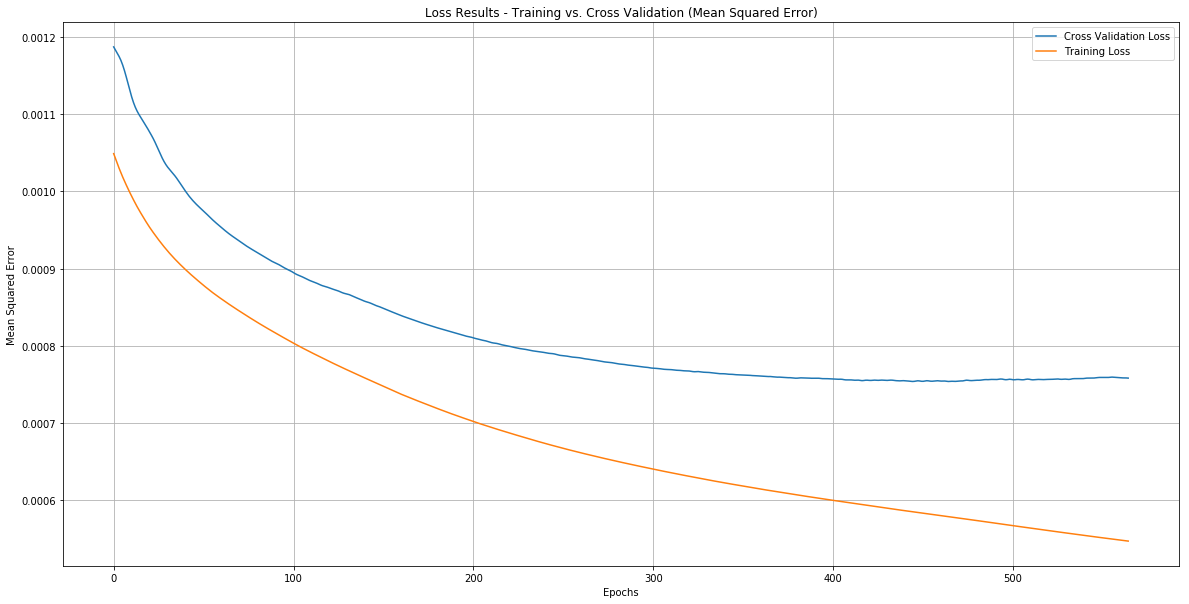

          Forecast : [401 387 448 444 469 526 609 609 522 441 403 439]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 146.09988403320312 Passengers
    Absolute Error : 2.56%


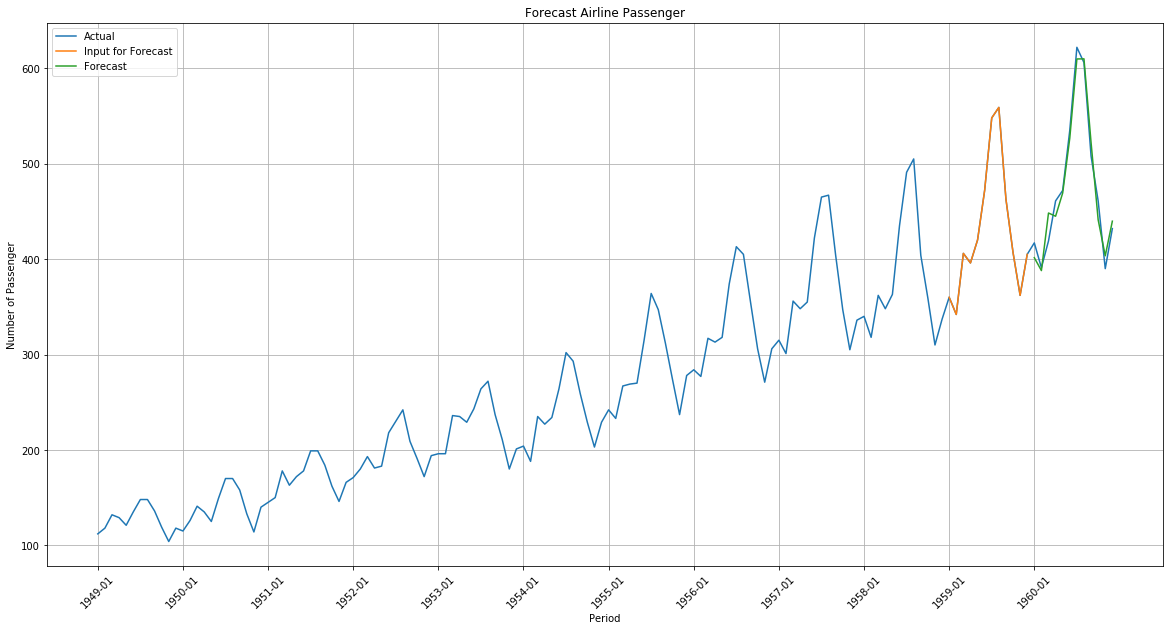

In [7]:
show_loss(histories[8])
show_results(df,scaler.inverse_transform(predictX),pYCol[8])

Last Results loss:0.000590446637943387, cross validation loss:0.0007607704028487206


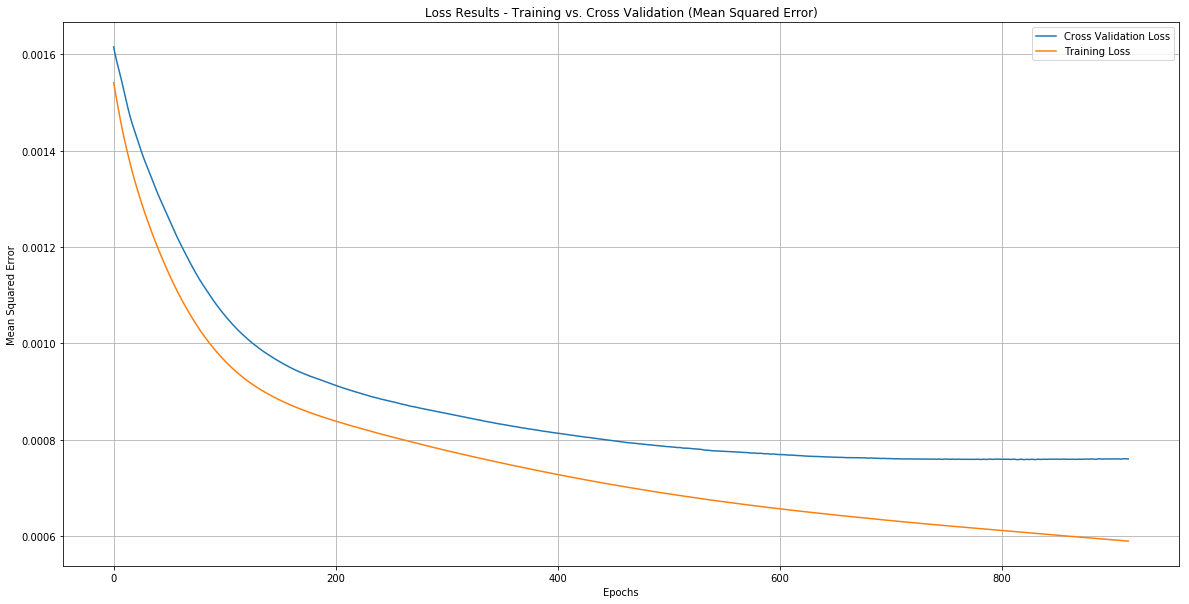

          Forecast : [412 392 423 470 488 522 595 605 515 430 403 428]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 130.49017333984375 Passengers
    Absolute Error : 2.29%


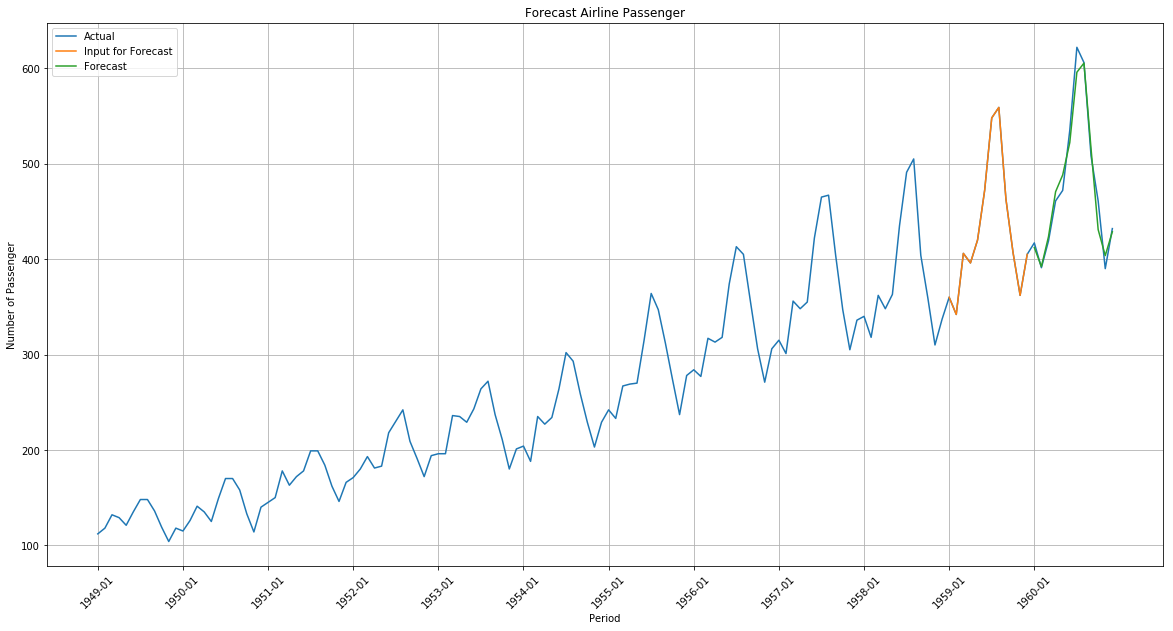

In [8]:
show_loss(histories[7])
show_results(df,scaler.inverse_transform(predictX),pYCol[2])

Last Results loss:0.0006234923494048417, cross validation loss:0.0007725726463831961


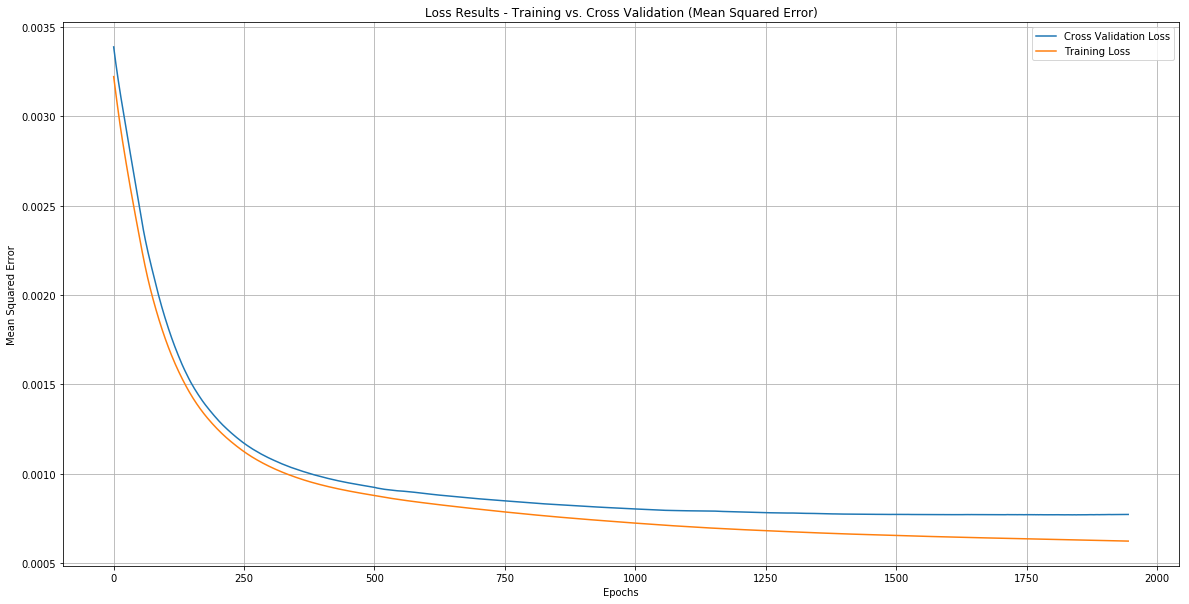

          Forecast : [403 409 424 435 462 538 597 574 525 438 411 408]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 216.54019165039062 Passengers
    Absolute Error : 3.85%


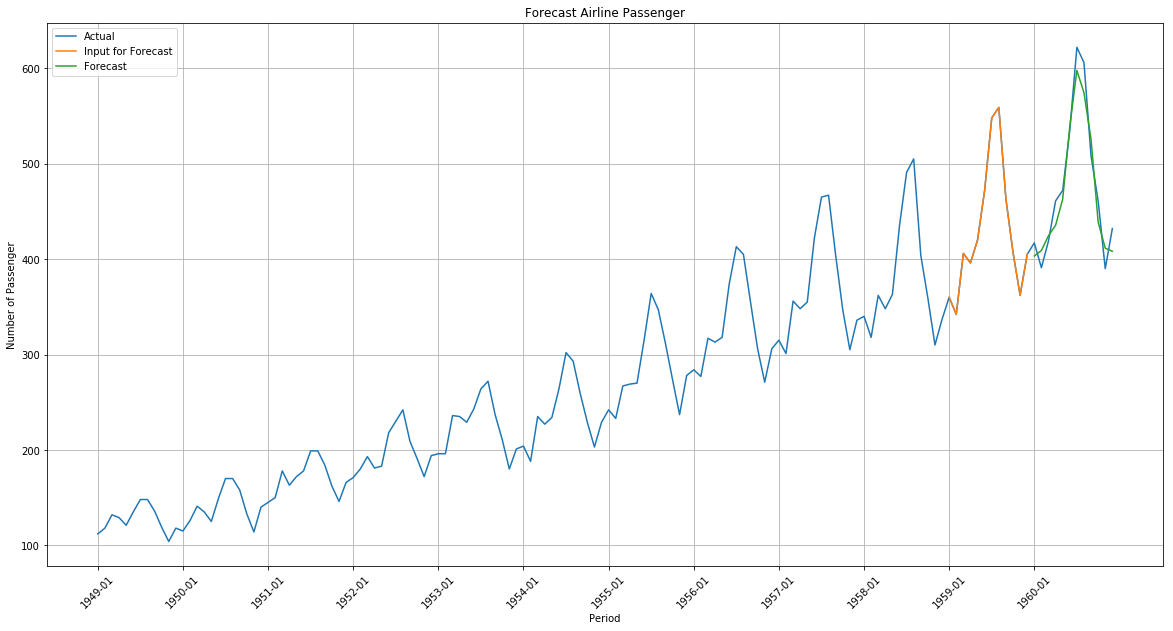

In [9]:
show_loss(histories[4])
show_results(df,scaler.inverse_transform(predictX),pYCol[3])